## PortfolioTimeSeries.ipynb

Code for the Chicago Booth course on Quantitative Portfolio Management by Ralph S.J. Koijen and Federico Mainardi.

### Preliminaries

This code builds time-series portfolio strategies. *This notebook also contains the questions for problem set 2.*
- As always, the data can be found in the dropbox folder: You can download the data from: https://www.dropbox.com/scl/fo/hrjspow2cpstfnoeqb23v/h?rlkey=j4fohf1s4e6fdy49p7bs71b7l&dl=0.
- Please download the file `ETFdata_small.parquet`. 

We first load several packages to initialize Python.

In [4]:
import statsmodels.formula.api as sm
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import wrds 
import qpm
import qpm_download

pd.options.mode.chained_assignment = None

Select wether you would like to download data directly from WRDS (`import_data` = True) or to load data from Dropbpx (`import_data` = False). If you decide to load data from Dropbox, make sure to define the data directoy (`_DATA_DIR`).

In [5]:
import_data = True             # <-- Edit this line
_DATA_DIR = '../Data'           # <-- Edit this line

We can select the sample period and ticker here. We can select an ETF covering the financial sector (ticker: XLF) or the S&P500 (ticker: SPY). To keep the data files initially small so that the code runs quickly, the file only contains two tickers. 

However, we can adjust this to any ticker. The file `ETFdata.parquet` contains thousands of ETFs and you can use these data for your final project. These ETFs allow you to explore other assets classes, industries or countries. For an overview of available ETFs, you can for instance visit this website: https://etfdb.com/etfs/. 

In [6]:
# Select the sample period
_SAMPLE_START = '2005-01-01'
_SAMPLE_END = '2023-07-31'

# Select the ticker
_ETF_TICKER = 'SPY'

Now we're ready to start!

### Step 1. Load Data

We first load the *daily* ETF data and we store it in `df_ETF`. If you selected import_data = True, the code will download and construct the data directly from WRDS. Otherwise, the code will import data that you downloaded from the Dropbox folder.

In [8]:
if import_data == True: 
    
    df_ETF_raw = qpm_download.time_series(_SAMPLE_START, _SAMPLE_END)
        
if import_data == False:
    
    # Load the data
    df_ETF_raw = pd.read_parquet('%s/ETFdata_small.parquet' %(_DATA_DIR))    

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Step 1. Import Daily Data
Done
Step 2. Import Monthly Data
Done
Step 3. Import Fama-French Factors


For each ETF, we have the daily return, `retd`, and the return of that month, `retM`. We use the daily return to compute the standard deviation below. The variable `date` is the daily date; the variable `ym` is the year and month. 

The factors (`mktrf` = excess return on the market, `smb` = the Fama and French size factor, `hml` = the Fama and French value factor, `rf` = the risk-free rate, `umd` = the momentum factor) are all *monthly* variables. In the dataset available in Dropbox, we also include the `CPI`, `inflation`, and `yr5breakeven`, which is the 5-year break-even inflation rate. We include those in case you like to explore strategies related to inflation risk, which is an important theme in the industry at the moment. We drop these data for this problem set as we don't need them.

In [9]:
# Select the ETF using the ticker symbol
df_ETF = df_ETF_raw[df_ETF_raw['ticker'] == _ETF_TICKER]

# Select the relevant variables for our strategy
df_ETF = df_ETF[['date', 'ym', 'retd', 'retM', 'mktrf', 'rf']]

# Sort the data
df_ETF.sort_values(['date'], inplace = True)

# Print the data 
df_ETF

,date,ym,retd,retM,mktrf,rf
0,2003-01-02,2003-01-01,0.032189,-0.024595,-0.0257,0.0010
1,2003-01-03,2003-01-01,0.003075,-0.024595,-0.0257,0.0010
2,2003-01-06,2003-01-01,0.017625,-0.024595,-0.0257,0.0010
3,2003-01-07,2003-01-01,-0.002474,-0.024595,-0.0257,0.0010
4,2003-01-08,2003-01-01,-0.014451,-0.024595,-0.0257,0.0010
...,...,...,...,...,...,...
10333,2023-07-25,2023-07-01,0.002730,0.032733,0.0321,0.0045
10334,2023-07-26,2023-07-01,0.000154,0.032733,0.0321,0.0045
10335,2023-07-27,2023-07-01,-0.006630,0.032733,0.0321,0.0045
10336,2023-07-28,2023-07-01,0.009790,0.032733,0.0321,0.0045


### Step 2. Portfolio Construction

To compute the standard deviation, we first group the data by month.

In [10]:
grouped = df_ETF.groupby('ym')

Next, we compute the statistic we need per month for each variable. For the daily returns, we need the standard deviation. For the monthly returns, we just pick the first observation (as those variables are constant within a given month). The following code then computes these statistics and provides a dataset that has one observation per month. We call the standard deviation of daily returns `sd`.

In [11]:
df = grouped.agg({
    'retd': 'std',
    'retM': 'first',
    'rf': 'first',
    'mktrf': 'first'
})
df = df.rename(columns={'retd': 'sd'})
df

,sd,retM,rf,mktrf
ym,,,,
2003-01-01,0.014982,-0.024595,0.0010,-0.0257
2003-02-01,0.011635,-0.013479,0.0009,-0.0188
2003-03-01,0.016972,0.002289,0.0010,0.0109
2003-04-01,0.011782,0.084612,0.0010,0.0822
2003-05-01,0.009799,0.054836,0.0009,0.0605
...,...,...,...,...
2023-03-01,0.011428,0.036936,0.0036,0.0251
2023-04-01,0.007591,0.015975,0.0035,0.0061
2023-05-01,0.008056,0.004616,0.0036,0.0035


We can only form portfolios based on information that we know in advance. For instance, for the portfolio that we hold in October 2023, we can only use data that we know in September 2023. We therefore lag the volatility signal by one period. 
- We compute the lag using `shift` as we have seen in the mean-variance problem set. We then annualize the standard deviation by the square root of the number of trading days, $\sqrt{252}$.


In [12]:
df['Lsd'] = df['sd'].shift(1) * np.sqrt(252)
df

,sd,retM,rf,mktrf,Lsd
ym,,,,,
2003-01-01,0.014982,-0.024595,0.0010,-0.0257,NaN
2003-02-01,0.011635,-0.013479,0.0009,-0.0188,0.237840
2003-03-01,0.016972,0.002289,0.0010,0.0109,0.184698
2003-04-01,0.011782,0.084612,0.0010,0.0822,0.269417
2003-05-01,0.009799,0.054836,0.0009,0.0605,0.187029
...,...,...,...,...,...
2023-03-01,0.011428,0.036936,0.0036,0.0251,0.155672
2023-04-01,0.007591,0.015975,0.0035,0.0061,0.181410
2023-05-01,0.008056,0.004616,0.0036,0.0035,0.120508


There is one missing value created, but we will take care of this in constructing the portfolio weights.

We are now ready to compute the portfolio weight as
$$w(t) = \min\left\{\frac{c}{\sigma_t},2\right\},$$
where $c$ is a scaling factor. It determines the amount of risk we'd like to take. Higher values of $c$ correspond to riskier strategies. We want to have an average $\beta$ of about 1. We choose $c=1.25 \times \overline{\sigma_t}$, where $\overline{\sigma_t}$ is the average volatility, $\sigma_t$. We take 1.25 so that the average $\beta$ is around one. We take the minimum of $\frac{c}{\sigma_t}$ and 2 to avoid that the portfolio gets too extreme during low volatility periods. 

The code has three steps
1. Compute the scaling $c$.
2. Compute the portfolio weight. Note that in computing the portfolio weight, it ends with `fillna(1)`. This means that missing portfolio weights (caused by the missing value of the standard deviation above) are replaced with 1, that is, invest all capital in the ETF.
3. In the final step, we drop the data from the standard deviation (`sd`), the lagged standard deviation (`Lsd`) and the scaling factor (`c`), as we no longer need those for the remainder of the code.

In [13]:
df['c'] = 1.25 * df['Lsd'].mean()
df['weight'] = np.minimum(df['c'] / df['Lsd'], 2).fillna(1)
df.drop(columns = ['sd','Lsd', 'c'], inplace = True)
df

,retM,rf,mktrf,weight
ym,,,,
2003-01-01,-0.024595,0.0010,-0.0257,1.000000
2003-02-01,-0.013479,0.0009,-0.0188,0.824854
2003-03-01,0.002289,0.0010,0.0109,1.062179
2003-04-01,0.084612,0.0010,0.0822,0.728175
2003-05-01,0.054836,0.0009,0.0605,1.048943
...,...,...,...,...
2023-03-01,0.036936,0.0036,0.0251,1.260228
2023-04-01,0.015975,0.0035,0.0061,1.081431
2023-05-01,0.004616,0.0036,0.0035,1.627962


We can now compute the return on the portfolio
$$r_p(t) = w(t) r_{ETF}(t)+[1-w(t)]r_f(t).$$
The first line computes the raw return, and the next two lines compute the excess return by subtracting the risk-free rate.

In [14]:
# Returns on the volatility timing strategy
df['retP'] = df['weight'] * df['retM'] + (1 - df['weight']) * df['rf']

# Excess returns on the volatility timing strategy
df['reteP'] = df['retP'] - df['rf']

# Excess returns on the ETF itself (without volatility timing)
df['reteM'] = df['retM'] - df['rf']

# Drop the risk-free rate from the data as we no longer need it
df.drop(columns = ['rf'], inplace = True)

df

,retM,mktrf,weight,retP,reteP,reteM
ym,,,,,,
2003-01-01,-0.024595,-0.0257,1.000000,-0.024595,-0.025595,-0.025595
2003-02-01,-0.013479,-0.0188,0.824854,-0.010961,-0.011861,-0.014379
2003-03-01,0.002289,0.0109,1.062179,0.002370,0.001370,0.001289
2003-04-01,0.084612,0.0822,0.728175,0.061884,0.060884,0.083612
2003-05-01,0.054836,0.0605,1.048943,0.057476,0.056576,0.053936
...,...,...,...,...,...,...
2023-03-01,0.036936,0.0251,1.260228,0.045611,0.042011,0.033336
2023-04-01,0.015975,0.0061,1.081431,0.016991,0.013491,0.012475
2023-05-01,0.004616,0.0035,1.627962,0.005254,0.001654,0.001016


We are done building the strategy! Let's analyze the returns now.

### Step 3. Portfolio Analytics

We first select the sample period that we would like to study.

In [15]:
df = df[(df.index >= _SAMPLE_START) & (df.index <= _SAMPLE_END)]
df

,retM,mktrf,weight,retP,reteP,reteM
ym,,,,,,
2005-01-01,-0.022421,-0.0276,2.000000,-0.046442,-0.048042,-0.024021
2005-02-01,0.020904,0.0189,1.954202,0.039324,0.037724,0.019304
2005-03-01,-0.018262,-0.0197,1.817270,-0.034903,-0.037003,-0.020362
2005-04-01,-0.018735,-0.0261,1.868233,-0.036825,-0.038925,-0.020835
2005-05-01,0.032225,0.0365,1.279796,0.040569,0.038169,0.029825
...,...,...,...,...,...,...
2023-03-01,0.036936,0.0251,1.260228,0.045611,0.042011,0.033336
2023-04-01,0.015975,0.0061,1.081431,0.016991,0.013491,0.012475
2023-05-01,0.004616,0.0035,1.627962,0.005254,0.001654,0.001016


Let's plot the portfolio weights to see what the strategy does.

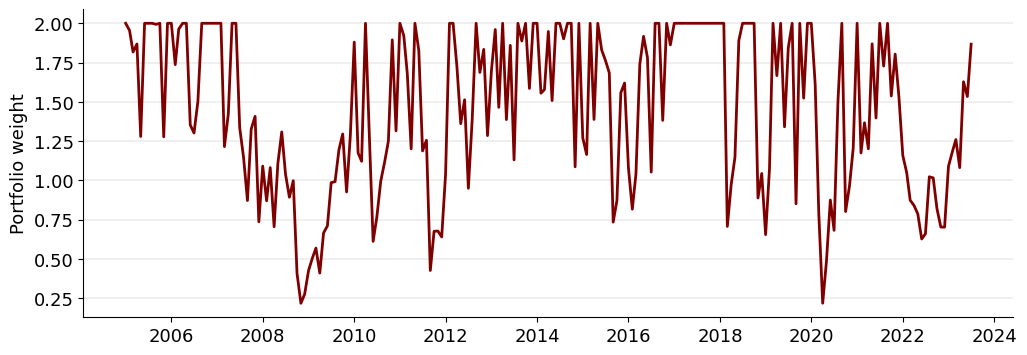

In [16]:
fig, ax = plt.subplots()
ax.plot(df.index, df['weight'], linewidth=2.0)
plt.ylabel('Date')
plt.ylabel('Portfolio weight')
plt.show()

Plot cumulative returns:

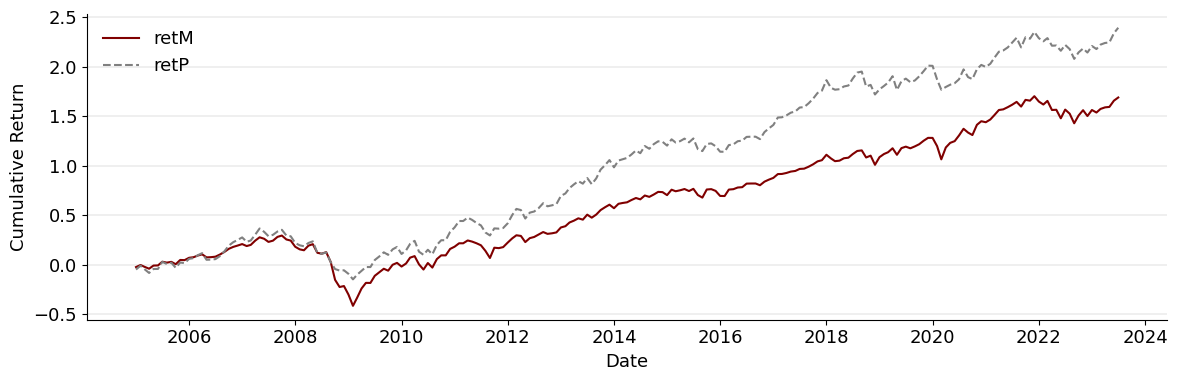

In [17]:
qpm.plot_cumulative_returns_etf(df, var_list = ['retM', 'retP'])

The next block computes the *annualized* average return, the standard deviation, and Sharpe ratio for each of the strategies.

In [18]:
# Compute summary statistics, and only keep the mean and the standard deviation
summary = df[['reteM', 'reteP']].describe().T[['mean', 'std']]

# Annualize the mean
summary['mean'] = summary['mean'] * 12

# Annualize the standard deviation
summary['std'] = summary['std'] * np.sqrt(12)

# Compute the Sharpe ratio
summary['sr'] = summary['mean'] / summary['std']

# Print the mean, standard deviation, and Sharpe ratio
print(summary.round(3))

        mean    std     sr
reteM  0.090  0.151  0.595
reteP  0.132  0.174  0.757


Now let's see whether the strategy using `SPY` generates alpha. We use the market excess return as our benchmark. You can change the end of the sample by modifying the date `2019-12-01`. In the first case, we stop before 2020.

In [19]:
# Select the sample
reg_df_select = df[df.index <= '2019-12-01']

# Run a regression of reteP (the excess return on the vol timed strategy) on the excess return of the market
result = sm.ols('reteP ~ mktrf', data=reg_df_select).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  reteP   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     666.7
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           4.33e-62
Time:                        21:09:48   Log-Likelihood:                 432.38
No. Observations:                 180   AIC:                            -860.8
Df Residuals:                     178   BIC:                            -854.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0039      0.002      2.354      0.0

Let's interpret the output. There are 180 observations, that is, 180 months. The constant is the alpha, and it equals 0.39% per month. This implies an annual alpha of 12 * 0.39 = 4.68%. The corresponding t-statistic is 2.35. This implies that the alpha is signifficantly positive at conventional levels (-1.96 and 1.96 are the usual cutoffs).

The beta is 1.03 (the coefficient corresponding to mktrf). It is also highly significant. Hence, we here have a strategy that simply times the market based on volatility and it generates an alpha of almost 5% a year. 

# Question 1

Run the same regression but now including the data from 2020, the year of the COVID downturn (and recovery). Use the code in the previous cell and change the date to `2020-12-31`. How does the performance change and what is the economic interpretation?

In [26]:
## Insert your code here# Select the sample
reg_df_select = df[df.index <= '2020-12-31']

# Run a regression of reteP (the excess return on the vol timed strategy) on the excess return of the market
result = sm.ols('reteP ~ mktrf', data=reg_df_select).fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                  reteP   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     253.1
Date:                Tue, 10 Oct 2023   Prob (F-statistic):           8.77e-37
Time:                        15:14:05   Log-Likelihood:                 311.81
No. Observations:                 192   AIC:                            -619.6
Df Residuals:                     190   BIC:                            -613.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0014      0.004     -0.390      0.6

Now let's explore the financial markets ETF. We change the ticker to `XLF` and run the same code as before. We collect the relevant code in the cell below. You can run it without modifications.

In [21]:
# Re-run the code from above but now for XLF

_ETF_TICKER = 'XLF'

# Load the data 
df_ETF = df_ETF_raw[df_ETF_raw['ticker'] == _ETF_TICKER]
df_ETF.sort_values(['date', 'ym'], inplace = True)

# Compute the standard deviation and keep one observation per month
grouped = df_ETF.groupby('ym')
df = grouped.agg({
    'retd': 'std',
    'retM': 'first',
    'rf': 'first',
    'mktrf': 'first'
})
df = df.rename(columns={'retd': 'sd'})

# Compute the lagged standard deviation 
df['Lsd'] = df['sd'].shift(1) * np.sqrt(252)

# Compute the scaling
df['c'] = 1.25 * df['Lsd'].mean()

# Compute the portfolio weight
df['weight'] = np.minimum(df['c'] / df['Lsd'], 2).fillna(1)

# Compute strategy returns, excess strategy returns, and the excess return on the ETF itself
df['retP'] = df['weight'] * df['retM'] + (1 - df['weight']) * df['rf']
df['reteP'] = df['retP'] - df['rf']
df['reteM'] = df['retM'] - df['rf']

# Select the sample
df = df[(df.index >= _SAMPLE_START) & (df.index <= _SAMPLE_END)]

reg_df_select = df

print("Done rebuilding the data...")

Done rebuilding the data...


Recall that `reteM` is the excess return on the untimed ETF. We first measure the performance of this ETF, untimed, by regressing it on the benchmark. 

In [22]:
# Regress the ETF excess return (untimed) on the excess return on the market
result = sm.ols('reteM ~ mktrf', data=reg_df_select).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  reteM   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     602.3
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           4.82e-65
Time:                        21:42:34   Log-Likelihood:                 442.07
No. Observations:                 223   AIC:                            -880.1
Df Residuals:                     221   BIC:                            -873.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0050      0.002     -2.197      0.0

The underperformance is quite large. The alpha is -0.5% per month, or -6.0% per year. The alpha is statistically significant. Now let's explore whether volatility timing helps. 

# Question 2

Consider a performance regression of the volatility-timed XLF using the same benchmark, as before. For the sample, we can use the full sample. Describe the results.

In [23]:
## Insert your code here
# Regress the ETF excess return (untimed) on the excess return on the market
result = sm.ols('reteP ~ mktrf', data=reg_df_select).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  reteP   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     272.2
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           2.15e-40
Time:                        21:46:50   Log-Likelihood:                 351.94
No. Observations:                 223   AIC:                            -699.9
Df Residuals:                     221   BIC:                            -693.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0009      0.003     -0.252      0.8

# Question 3
Repeat this exercise, but now using the untimed XLF returns as the benchmark, and the full sample. Describe the economic and statistical significance of the results. For which investors would the results in this analysis be particularly relevant?

In [24]:
## Insert your code here
result = sm.ols('reteP ~ reteM', data=reg_df_select).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  reteP   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     578.0
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           1.33e-63
Time:                        21:51:04   Log-Likelihood:                 405.74
No. Observations:                 223   AIC:                            -807.5
Df Residuals:                     221   BIC:                            -800.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0043      0.003      1.612      0.1

Done!